In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

--2025-02-28 01:57:21--  https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip [following]
--2025-02-28 01:57:22--  https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56097894 (53M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  53.

In [ ]:
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
  inflating: image/resize_CHNCXR_0001_0.png  
  inflating: image/resize_CHNCXR_0002_0.png  
  inflating: image/resize_CHNCXR_0003_0.png  
  inflating: image/resize_CHNCXR_0004_0.png  
  inflating: image/resize_CHNCXR_0005_0.png  
  inflating: image/resize_CHNCXR_0006_0.png  
  inflating: image/resize_CHNCXR_0007_0.png  
  inflating: image/resize_CHNCXR_0008_0.png  
  inflating: image/resize_CHNCXR_0009_0.png  
  inflating: image/resize_CHNCXR_0010_0.png  
  inflating: image/resize_CHNCXR_0011_0.png  
  inflating: image/resize_CHNCXR_0012_0.png  
  inflating: image/resize_CHNCXR_0013_0.png  
  inflating: image/resize_CHNCXR_0014_0.png  
  inflating: image/resize_CHNCXR_0015_0.png  
  inflating: image/resize_CHNCXR_0016_0.png  
  inflating: image/resize_CHNCXR_0017_0.png  
  inflating: image/resize_CHNCXR_0018_0.png  
  inflating: image/resize_CHNCXR_0019_0.png  
  inflating: image/resize_CHNCXR_0020_0.png  
  inflating: image/resize_CHNCXR_0021_0.png  
  

Watershed 알고리즘 적용

In [ ]:
import os
import numpy as np
from scipy import ndimage #이미지 처리를 위한 라이브러리
from skimage.io import imread #이미지 파일을 읽기 위한 라이브러리
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.feature import peak_local_max #지역에서 최댓값을 찾는 함수
from skimage.segmentation import watershed #워터쉐드 알고리즘 함수
from skimage.measure import label #연결된 영역 레이블링 함수
from skimage.morphology import remove_small_objects #작은 객체를 제거하는 함수

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3 #image를 256X256X3으로 진행

data_path = "/content/"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)

#print(file_headers) #이미지 폴더의 모든 파일들을 불러와 확장자를 제거하여 파일명을 가져온다

X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

y_all = np.zeros((len(file_headers),IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32)

count = 0 #X_all과 y_all이라는 빈 배열을 생성한다.

def separate_lungs_watershed(lung_mask): #watershed 알고리즘으로 lung mask를 분리하기 위한 함수

    #작은 노이즈 제거
    cleaned_mask = remove_small_objects(lung_mask.astype(bool), min_size=100) #최소 크기를 100으로 잡는다
    cleaned_mask = cleaned_mask.astype(np.float32) #float32타입 변환

    #노이즈를 제거하는 이유는 워터쉐드 알고리즘의 정확도를 높이기 위해 사전 제거
    #remove_small_objects 함수가 boolean 마스크만 입력값으로 받기 때문에 bool 타입으로 변환
    #min_size를 100픽셀로 잡아 100픽셀보다 작은 영역은 폐 영역으로 보지 않는다고 하한선을 정함
    #(min_size를 0으로 잡게 되면 노이즈 제거가 되지 않기 때문에 권장하지 않음)

    #각 픽셀에서 가장 가까운 배경까지의 거리를 계산
    distance = ndimage.distance_transform_edt(cleaned_mask)

    #distance_transform_edt는 각 픽셀에서 가장 가까운 배경(0)까지의 유클리드 거리를 계산
    #이는 폐 영역의 중심부는 배경에서 멀리 있어 거리가 멀고, 폐 영역의 경계부는 배경과 가까워 거리가 가깝다
    #계산한 거리값들은 고도나 깊이 같이 작용해서 워터쉐드 알고리즘의 기반이 된다.


    #각 폐의 중심점이 될 위치를 찾는다
    local_max = peak_local_max(distance, labels=cleaned_mask.astype(bool), num_peaks = 2, min_distance=100,threshold_abs=0.5,threshold_rel = 0.5)

    #distance는 앞서 계산한 거리 변환 맵 (높은 값일수록 폐의 중심부와 가깝다)
    #num_peaks를 2는 폐 영역 내에서만 피크를 찾기 위해 (폐 마스크가 2개기 때문)
    #min_distance = 100 은 피크 간 최소 거리를 100으로 설정 (너무 가까운 곳에서 검출되는 것을 방지)
    #threshold_abs = 0.5는 절대 임계값 (0.5보다 큰 값에 대해서만 피크로 고려)
    #threshold_rel = 0.5는 상대 임계값 (최대 거리의 50% 이상인 것만 고려)
    #결과는 (x,y) 같이 좌표로 출력되고 이 좌표들은 각 폐의 중심점 --> 마커로 사용된다.

    #워터쉐드 알고리즘을 본격 적용하기 위해 마커를 생성한다
    markers = np.zeros_like(cleaned_mask,dtype=int) #마커 배열 초기화
    markers[tuple(local_max.T)] = range(1,len(local_max) + 1) #피크 위치에 번호를 부여

    #np.zeros_like(cleaned_mask)로 cleaned_mask와 같은 크기의 배열을 만들고 배열값은 0으로 통일
    #local_max는 [y,x] 좌표로 나타나는데 local_max.T처럼 전치행렬로 해주면 [[y1,y2],[x1,x2]] 처럼 됨
    #두 번째 코드처럼 마커를 설정하면 markers[y1,y2]는 첫 번째 피크, markers[x1,x2]는 두 번째 피크


    #워터쉐드 적용
    labels = watershed(-distance, markers, mask=cleaned_mask.astype(bool))
    #각 마커에서 시작해 영역이 점차 퍼져나가면서 전체 폐 영역을 두 개의 영역으로 분할

    #레이블된 영역의 무게중심 계산
    regions = ndimage.find_objects(labels) #labels 배열에서 좌우 폐의 bounding box를 찾음

    if len(regions) == 2: #두 개의 영역이 제대로 검출되었다면
        centroids = [ndimage.center_of_mass(labels == i) for i in [1,2]] #각 영역의 중심점 계산

        #좌우 폐 마스크 생성
        left_mask = np.zeros_like(cleaned_mask,dtype=np.float32)
        right_mask = np.zeros_like(cleaned_mask,dtype=np.float32)


        #x좌표 비교하여 좌,우 폐 구분
        if centroids[0][1] > centroids[1][1]: #x좌표 비교 (centroids[1][1]은 x좌표) 즉 첫번째 영역이 오른쪽이라면
            left_mask[labels == 1] = 1 #레이블이 1인 영역을 왼쪽 폐로
            right_mask[labels == 2] = 1 #레이블이 2인 영역을 오른쪽 폐로

        else: #첫 번째 영역이 왼쪽에 있다면
            left_mask[labels == 2] = 1 #레이블이 2인 영역을 왼쪽 폐로
            right_mask[labels == 1] = 1 #레이블이 1인 영역을 오른쪽 폐로

    else: #두 개의 영역이 검출되지 않는다면 하단의 예외 처리 구문을 실행
        labeled_array, num_features = ndimage.label(cleaned_mask)
        #labeled_array는 각 연결된 영역에 번호를 부여
        #num_features는 검출된 영역의 수

        if num_features >= 2: #검출된 영역의 수가 2개 이상이라면
            #각 영역의 무게중심 계산
            props = ndimage.center_of_mass(cleaned_mask,labeled_array,range(1,num_features + 1))
            #x좌표를 기준으로 정렬
            sorted_regions = sorted(enumerate(props,1),key=lambda x: x[1][1])

            left_mask = np.zeros_like(cleaned_mask, dtype = np.float32)
            right_mask = np.zeros_like(cleaned_mask, dtype = np.float32)

            #x좌표가 가장 작은 영역을 오른쪽 폐로
            right_mask[labeled_array == sorted_regions[0][0]] = 1
            #x좌표가 가장 큰 영역을 왼쪽 폐로
            left_mask[labeled_array == sorted_regions[-1][0]] = 1

    return left_mask, right_mask

count = 0


for fh in file_headers: #모든 이미지에 대해 watershed를 처리
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))

    img = imread(f1)[:,:,:IMG_CHANNELS]
    mask = imread(l1)

    #폐 영역(255)과 배경(0) 의 구분
    lung_mask = (mask == 255).astype(np.float32)

    background_mask = (mask == 0).astype(np.float32)

    #워터쉐드 알고리즘을 사용하여 좌,우 폐 분리
    left_mask , right_mask = separate_lungs_watershed(lung_mask)

    mask_one_hot = np.zeros((IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32)


    #각 채널에 마스크 할당
    mask_one_hot[:,:,0] = background_mask #배경
    mask_one_hot[:,:,1] = left_mask #왼쪽 폐 (이미지의 오른쪽)
    mask_one_hot[:,:,2] = right_mask #오른쪽 폐 (이미지의 왼쪽)

    #결과 저장
    X_all[count] = img
    y_all[count] = mask_one_hot

    count += 1 #처리한 이미지 수 증가

데이터 시각화

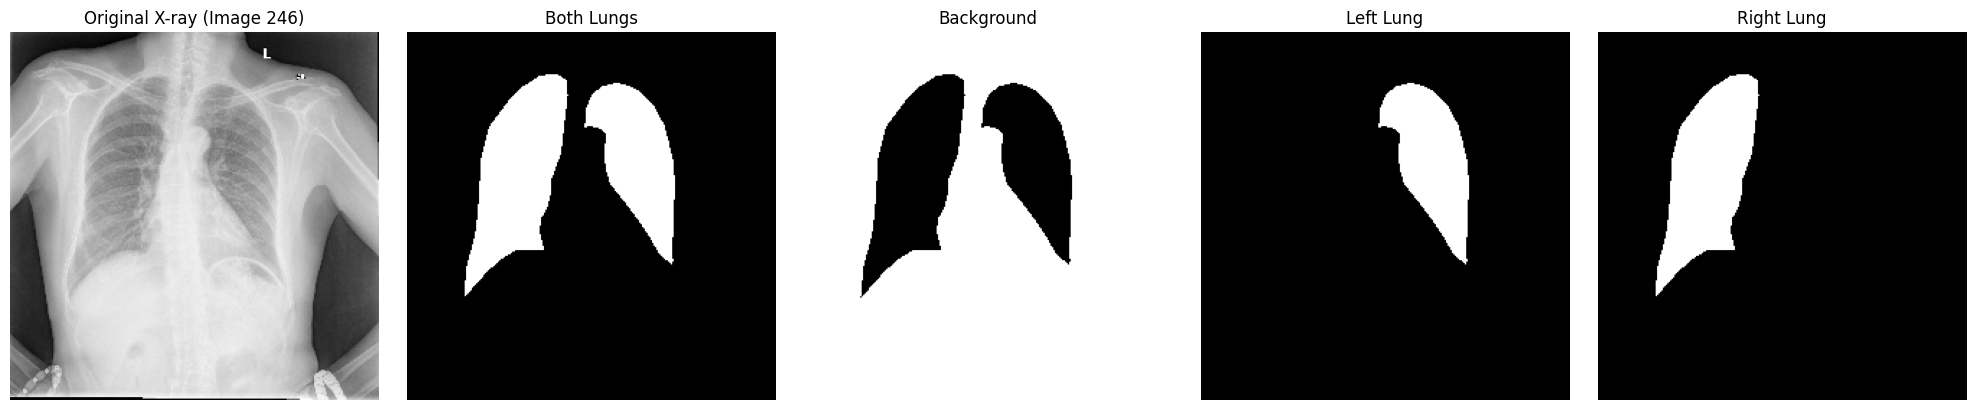

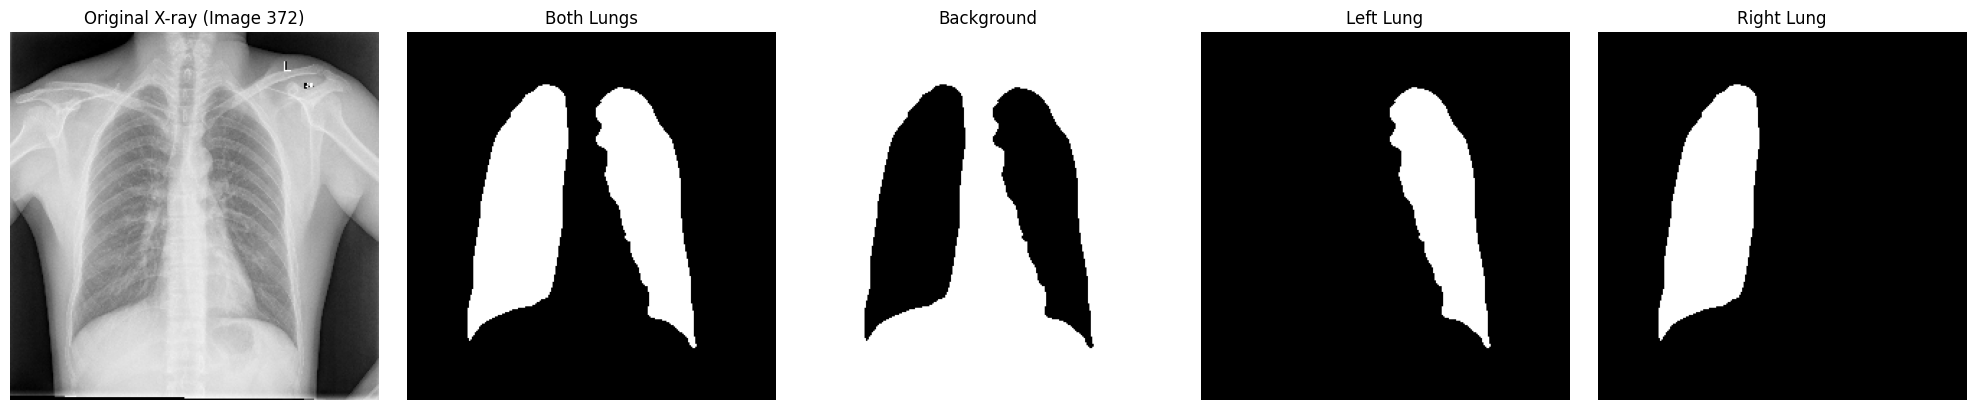

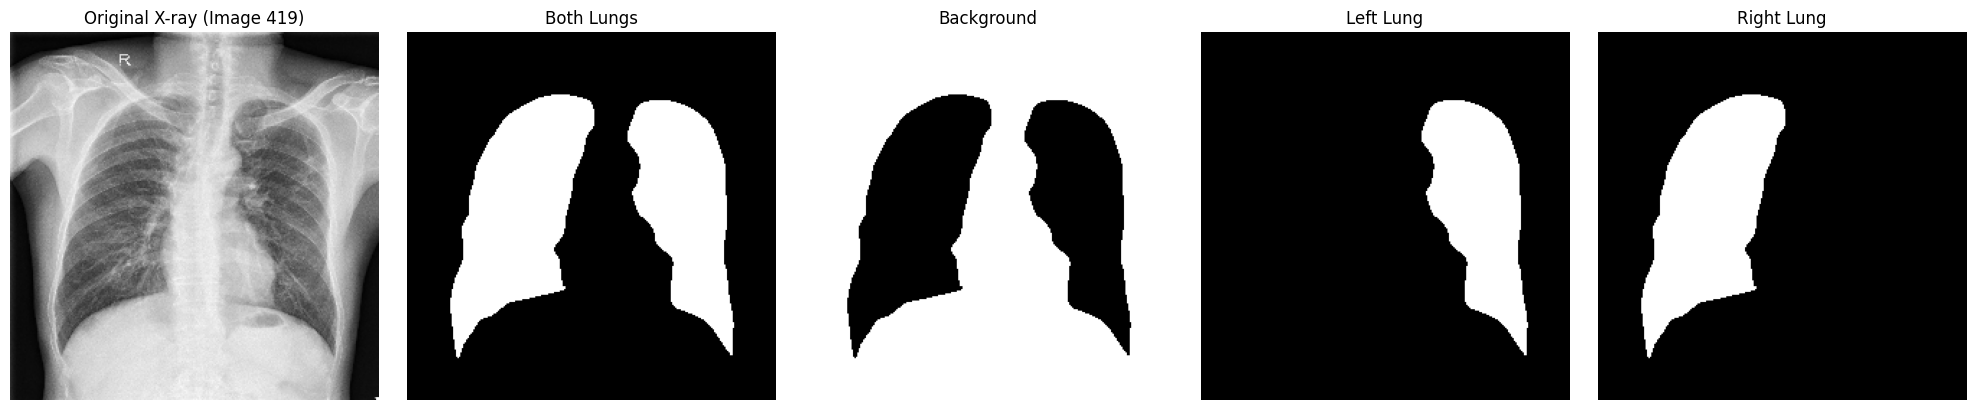

In [ ]:
import matplotlib.pyplot as plt

def visualize_watershed_results(X, y, num_samples=[246, 372, 419]):
    """
    특정 인덱스의 이미지에 대해 Watershed 분할 결과를 시각화하는 함수
    X: 원본 X-ray 이미지
    y: watershed로 분할된 마스크 (원-핫 인코딩)
    num_samples: 시각화할 이미지의 인덱스 리스트
    """
    for idx in num_samples:
        plt.figure(figsize=(20, 4))

        # 원본 X-ray 이미지
        plt.subplot(151)
        plt.title(f'Original X-ray (Image {idx})')
        plt.imshow(X[idx])
        plt.axis('off')

        # 전체 폐 마스크
        plt.subplot(152)
        plt.title('Both Lungs')
        plt.imshow(y[idx,:,:,1] + y[idx,:,:,2], cmap='gray')
        plt.axis('off')

        # 배경
        plt.subplot(153)
        plt.title('Background')
        plt.imshow(y[idx,:,:,0], cmap='gray')
        plt.axis('off')

        # 왼쪽 폐
        plt.subplot(154)
        plt.title('Left Lung')
        plt.imshow(y[idx,:,:,1], cmap='gray')
        plt.axis('off')

        # 오른쪽 폐
        plt.subplot(155)
        plt.title('Right Lung')
        plt.imshow(y[idx,:,:,2], cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 시각화 실행 (246번, 372번, 419번 이미지)
visualize_watershed_results(X_all, y_all)

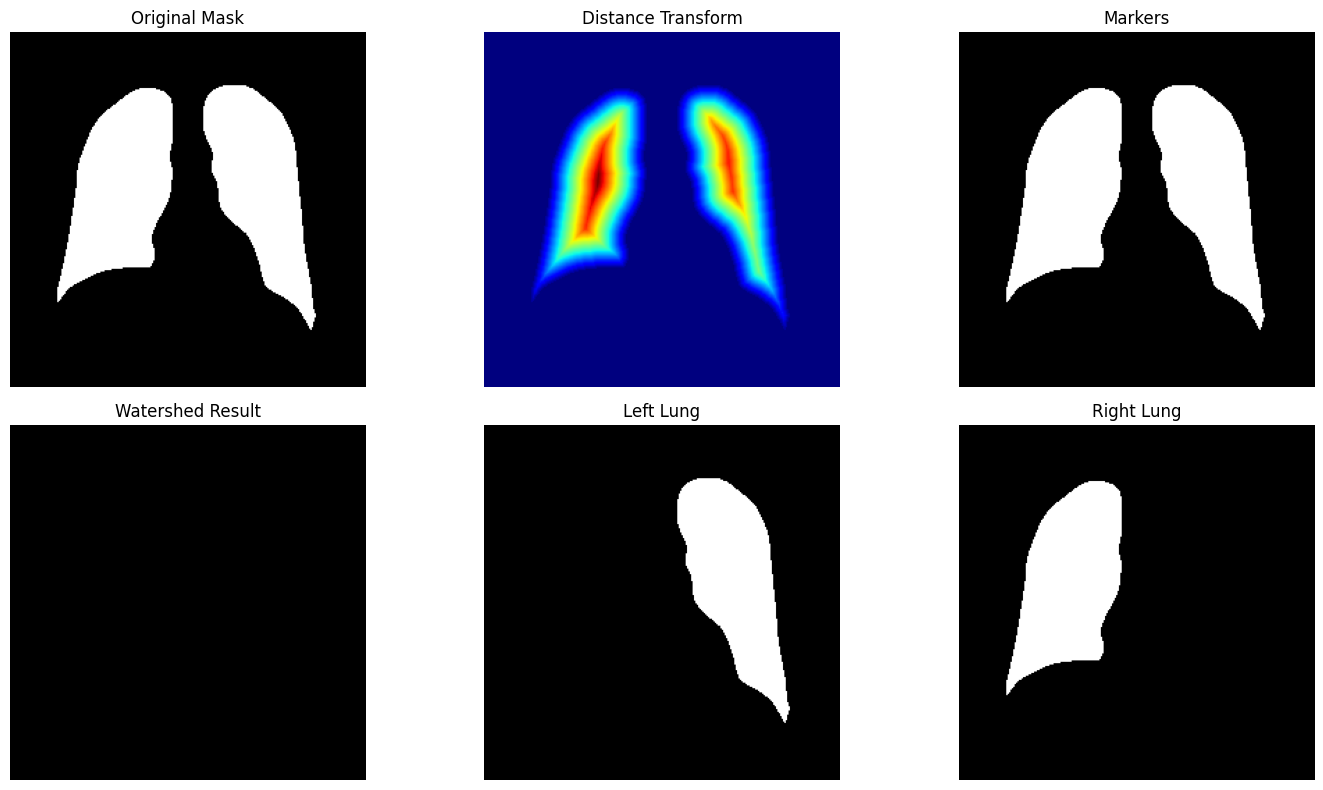

In [ ]:
def visualize_watershed_process(lung_mask):
    # 중간 과정 계산 (시각화용)
    cleaned_mask = remove_small_objects(lung_mask.astype(bool), min_size=100).astype(np.float32)
    distance = ndimage.distance_transform_edt(cleaned_mask)
    local_max = peak_local_max(distance, labels=cleaned_mask.astype(bool),
                             num_peaks=2, min_distance=100,
                             threshold_abs=0.5, threshold_rel=0.5)

    # 마커 생성
    markers = np.zeros_like(cleaned_mask, dtype=int)
    markers[tuple(local_max.T)] = range(1, len(local_max) + 1)

    # watershed 적용 (한 번만 실행)
    labels = watershed(-distance, markers, mask=cleaned_mask.astype(bool))

    # separate_lungs_watershed 함수로 좌우 폐 분리
    left_mask, right_mask = separate_lungs_watershed(lung_mask)

    # 시각화
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 원본 마스크
    axes[0,0].imshow(cleaned_mask, cmap='gray')
    axes[0,0].set_title('Original Mask')
    axes[0,0].axis('off')

    # 거리 변환 맵
    axes[0,1].imshow(distance, cmap='jet')
    axes[0,1].set_title('Distance Transform')
    axes[0,1].axis('off')

    # 마커
    axes[0,2].imshow(cleaned_mask, cmap='gray')
    axes[0,2].plot(local_max[:, 1], local_max[:, 0], 'r.', markersize=15)
    axes[0,2].set_title('Markers')
    axes[0,2].axis('off')

    # 워터쉐드 결과
   # Watershed Result 시각화 개선
    axes[1,0].imshow(labels, cmap='gray')  # 'gray' 컬러맵 사용
    axes[1,0].set_title('Watershed Result')
    axes[1,0].axis('off')

    # 왼쪽 폐
    axes[1,1].imshow(left_mask, cmap='gray')
    axes[1,1].set_title('Left Lung')
    axes[1,1].axis('off')

    # 오른쪽 폐
    axes[1,2].imshow(right_mask, cmap='gray')
    axes[1,2].set_title('Right Lung')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

# 시각화 실행 (예시)
idx = np.random.randint(0, len(X_all))
lung_mask = (imread(os.path.join(data_path, 'label', f'{file_headers[idx]}.png')) == 255).astype(np.float32)
visualize_watershed_process(lung_mask)

In [ ]:
X_all = X_all.astype('float32') / 255 #정규화

In [ ]:
X_all.shape
y_all.shape

(566, 256, 256, 3)

In [ ]:
seed = 7 #코드를 여러 번 실행해도 결과가 동일하게 출력되기 위해서 사용
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
#의료 이미지 분할을 목적으로 2D U-net 모델을 도입

from tensorflow.keras.layers import Concatenate

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) #256X256X3 -> 256X256X32 (32개의 3X3 필터가 연산 수행)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1) #256X256X32 -> 128X128X32

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #128X128X32 -> 128X128X64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2) #128X128X64 -> 64X64X64

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #64X64X64 -> 64X64X128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3) #64X64X128 -> 32X32X128

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #32X32X128 -> 32X32X256
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4) #32X32X256 -> 16X16X256

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4) #16X16X256 -> 16X16X512
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5) #16X16X512

#conv1 - conv5까지는 Encoder (Contracting path)이다.
#이 부분에서는 이미지의 크기가 점차 감소(maxpooling)하며 필터 수는 증가한다
#conv1에서는 보통 간단한 특징들을, 5로 갈수록 복잡한 특징(전체 구조) 등을 추출한다

    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4]) #16X16X512 -> 32X32X256
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6) #32X32X512
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6) #32X32X256

    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3]) #32X32X256 -> 64X64X128
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7) #64X64X256
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7) #64X64X128

    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2]) #64X64X128 -> 128X128X64
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8) #128X128X128
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8) #128X128X64

    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1]) #128X128X64 -> 256X256X32
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9) #256X256X64
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9) #256X256X32

#conv6-conv9 까지는 Decoder (Expanding path)이다
#이 부분은 이미지가 점차 확장되면서 원래 크기로 복원된다
#Concatenate 부분은 skip-connection으로 encoder와 같은 레벨의 특징과 결합 (1-9 2-8 3-7 4-6)


    conv10 = Conv2D(3, (1, 1), activation='softmax')(conv9) #최종 출력층, channels = 3 (배경, 왼쪽, 오른쪽)

    #다중 클래스 분류를 위해 활성화함수를 softmax로 하였다.
    #softmax는 각 픽셀 위치에서 세 클래스의 확률값의 합이 1이 되도록 한다 (각 픽셀이 어느 클래스인지 확률값으로)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
import tensorflow as tf

def dice_coef(y_true,y_pred,smooth=1.0): #평가지표로는 Dice Coefficient를 사용하였다.
    #segmentation에서 예측된 영역과 실제 영역의 겹치는 정도를 측정
    intersection = tf.reduce_sum(y_true * y_pred, axis = [1,2]) #교집합 계산 (axis =[1,2]는 높이와 너비 방향으로 합계 계산)
    union = tf.reduce_sum(y_true, axis = [1,2]) + tf.reduce_sum(y_pred, axis = [1,2]) #합집합 계산

    #각 클래스별 dice coefficient 계산
    dice = (2 * intersection + smooth) / (union + smooth) #공식 구현
    #모든 클래스에 대해 평균 계산
    return tf.reduce_mean(dice)

def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred) #Dice loss는 1에서 Dice Coefficient를 뺀 값으로 손실함수로써 정의

In [ ]:
#모델 컴파일
model = unet()
model.compile(
    optimizer = 'adam',
    loss=dice_coef_loss,
    metrics=[dice_coef,'accuracy']
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7304 - dice_coef: 0.6276 - loss: 0.3724
Epoch 1: val_dice_coef improved from -inf to 0.39049, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 84s 988ms/step - accuracy: 0.7331 - dice_coef: 0.6309 - loss: 0.3692 - val_accuracy: 0.5684 - val_dice_coef: 0.3905 - val_loss: 0.6128
Epoch 2/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9707 - dice_coef: 0.9412 - loss: 0.0588
Epoch 2: val_dice_coef did not improve from 0.39049
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9708 - dice_coef: 0.9413 - loss: 0.0587 - val_accuracy: 0.4338 - val_dice_coef: 0.2980 - val_loss: 0.7016
Epoch 3/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9715 - dice_coef: 0.9505 - loss: 0.0495
Epoch 3: val_dice_coef improved from 0.39049 to 0.48582, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.9716 - dice_coef: 0.9507 - loss: 0.0493 - val_accuracy: 0.7668 - val_dice_coef: 0.4858 - val_loss: 0.5141
Epoch 4/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9763 - dice_coef: 0.9602 - loss: 0.0398
Epoch 4: val_dice_coef improved from 0.48582 to 0.50587, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.9764 - dice_coef: 0.9603 - loss: 0.0397 - val_accuracy: 0.7550 - val_dice_coef: 0.5059 - val_loss: 0.4947
Epoch 5/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9763 - dice_coef: 0.9609 - loss: 0.0391
Epoch 5: val_dice_coef did not improve from 0.50587
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.9763 - dice_coef: 0.9609 - loss: 0.0391 - val_accuracy: 0.7482 - val_dice_coef: 0.2918 - val_loss: 0.7089
Epoch 6/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9770 - dice_coef: 0.9625 - loss: 0.0375
Epoch 6: val_dice_coef did not improve from 0.50587
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.9771 - dice_coef: 0.9625 - loss: 0.0375 - val_accuracy: 0.7715 - val_dice_coef: 0.5041 - val_loss: 0.4937
Epoch 7/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9781 - dice_coef: 0.9644 - loss: 0.0356
Epoch 7: val_dice_coef improved from 0.50587 to 0.66761, saving model to lung_segmentation_

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9781 - dice_coef: 0.9645 - loss: 0.0355 - val_accuracy: 0.8653 - val_dice_coef: 0.6676 - val_loss: 0.3308
Epoch 8/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9786 - dice_coef: 0.9655 - loss: 0.0345
Epoch 8: val_dice_coef did not improve from 0.66761
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.9786 - dice_coef: 0.9655 - loss: 0.0345 - val_accuracy: 0.8557 - val_dice_coef: 0.6437 - val_loss: 0.3551
Epoch 9/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9784 - dice_coef: 0.9652 - loss: 0.0348
Epoch 9: val_dice_coef did not improve from 0.66761
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.9784 - dice_coef: 0.9652 - loss: 0.0348 - val_accuracy: 0.8149 - val_dice_coef: 0.5175 - val_loss: 0.4806
Epoch 10/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9788 - dice_coef: 0.9660 - loss: 0.0340
Epoch 10: val_dice_coef improved from 0.66761 to 0.73141, saving model to lung_segmentati

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.9788 - dice_coef: 0.9661 - loss: 0.0339 - val_accuracy: 0.8878 - val_dice_coef: 0.7314 - val_loss: 0.2664
Epoch 11/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9792 - dice_coef: 0.9668 - loss: 0.0332
Epoch 11: val_dice_coef improved from 0.73141 to 0.93474, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9792 - dice_coef: 0.9668 - loss: 0.0332 - val_accuracy: 0.9637 - val_dice_coef: 0.9347 - val_loss: 0.0645
Epoch 12/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9785 - dice_coef: 0.9656 - loss: 0.0344
Epoch 12: val_dice_coef did not improve from 0.93474
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.9784 - dice_coef: 0.9655 - loss: 0.0345 - val_accuracy: 0.8011 - val_dice_coef: 0.6887 - val_loss: 0.3091
Epoch 13/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9741 - dice_coef: 0.9581 - loss: 0.0419
Epoch 13: val_dice_coef did not improve from 0.93474
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.9741 - dice_coef: 0.9582 - loss: 0.0418 - val_accuracy: 0.7852 - val_dice_coef: 0.7516 - val_loss: 0.2450
Epoch 14/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9750 - dice_coef: 0.9597 - loss: 0.0403
Epoch 14: val_dice_coef did not improve from 0.93474
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 18

46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9797 - dice_coef: 0.9679 - loss: 0.0321 - val_accuracy: 0.9791 - val_dice_coef: 0.9670 - val_loss: 0.0332
Epoch 20/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9800 - dice_coef: 0.9685 - loss: 0.0315
Epoch 20: val_dice_coef did not improve from 0.96700
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.9801 - dice_coef: 0.9685 - loss: 0.0315 - val_accuracy: 0.8759 - val_dice_coef: 0.7192 - val_loss: 0.2803
Epoch 21/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9802 - dice_coef: 0.9687 - loss: 0.0313
Epoch 21: val_dice_coef did not improve from 0.96700
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.9802 - dice_coef: 0.9687 - loss: 0.0313 - val_accuracy: 0.9702 - val_dice_coef: 0.9513 - val_loss: 0.0487
Epoch 22/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9797 - dice_coef: 0.9679 - loss: 0.0321
Epoch 22: val_dice_coef did not improve from 0.96700
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 1

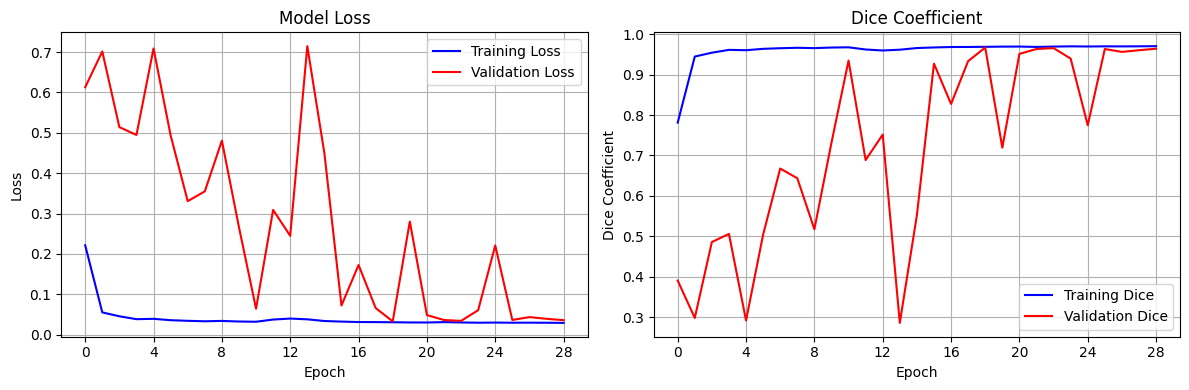

In [ ]:
#재현성을 위한 시드 설정
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(learning_rate = 1e-4)

#체크포인트만 정의
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_dice_coef', #검증 세트의 dice coefficient 모니터링
        mode='max', #dice coefficient는 높을 수록 좋음
        patience=10, #10에폭동안 개선이 없다면 학습을 중단
        restore_best_weights = True, #최적의 가중치 복원
        verbose=1
    ),

    ModelCheckpoint(
        'lung_segmentation_model.h5',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]


#모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid,y_valid),
    batch_size=8,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# 테스트 데이터에 대한 평가
test_results = model.evaluate(X_test, y_test, verbose=0)

# 최종 성능 출력
print("\n=== Final Model Performance ===")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Training Dice Coefficient: {history.history['dice_coef'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Validation Dice Coefficient: {history.history['val_dice_coef'][-1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")

#학습 과정 시각화
plt.figure(figsize=(12,4))

#loss 그래프
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'],'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(history.history['loss']), 4))


#Dice coefficient 그래프
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'],'b-', label='Training Dice')
plt.plot(history.history['val_dice_coef'],'r-', label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(history.history['dice_coef']), 4))


plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Training Dice Coefficient: 0.9821


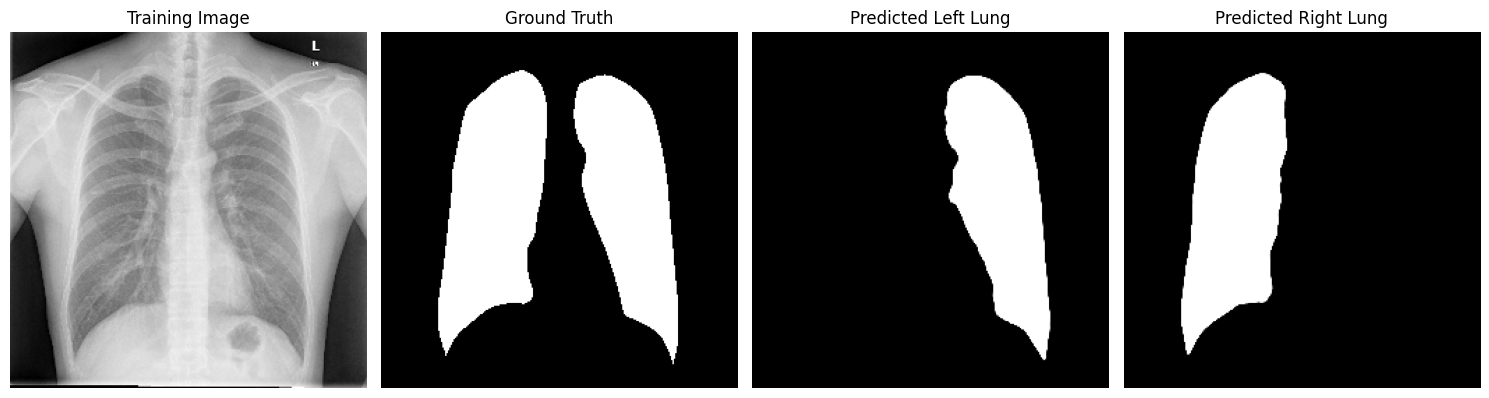

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Validation Dice Coefficient: 0.9841


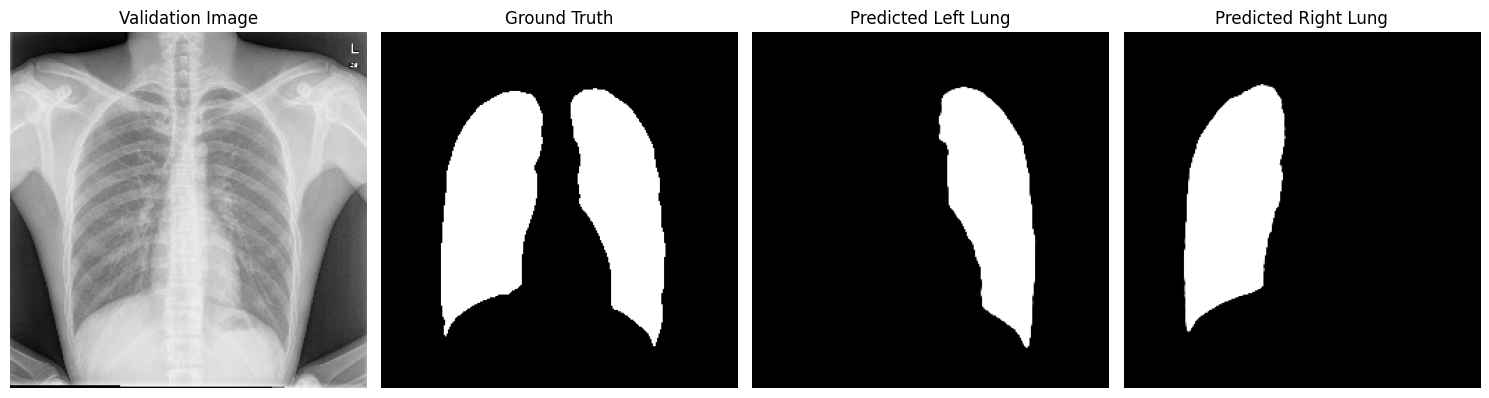

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test Dice Coefficient: 0.9799


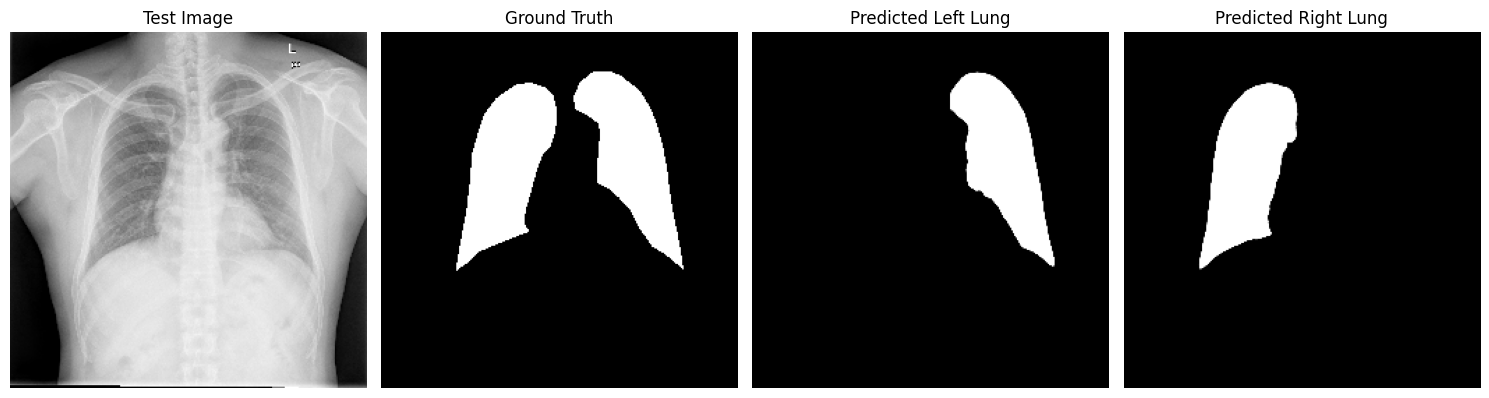

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, model):
    def plot_sample(X,y,pred,title_prefix):
        plt.figure(figsize=(15,5))

        #원본 이미지
        plt.subplot(1,4,1)
        plt.title(f"{title_prefix} Image")
        plt.imshow(X[0])
        plt.axis('off')

        #실제 마스크 (전체 폐)
        plt.subplot(1,4,2)
        plt.title("Ground Truth")

        #왼쪽 오른쪽 폐를 동시에 표시
        plt.imshow(y[0,:,:,1]+y[0,:,:,2], 'gray')
        plt.axis('off')

        #예측 마스크 (왼쪽 폐)
        plt.subplot(1,4,3)
        plt.title("Predicted Left Lung")
        plt.imshow(pred[0,:,:,1], 'gray')
        plt.axis('off')

        #예측 마스크 (오른쪽 폐)
        plt.subplot(1,4,4)
        plt.title("Predicted Right Lung")
        plt.imshow(pred[0,:,:,2],'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    #학습 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    ret = model.evaluate(input_, mask_,verbose=0)
    print(f"Training Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_train, "Training")

    #검증 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Validation Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_valid, "Validation")

    #테스트 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Test Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_test, "Test")

#모델 예측 결과 시각화
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

Training Data Predictions:
Training Sample 1 Dice Coefficient: 0.9477


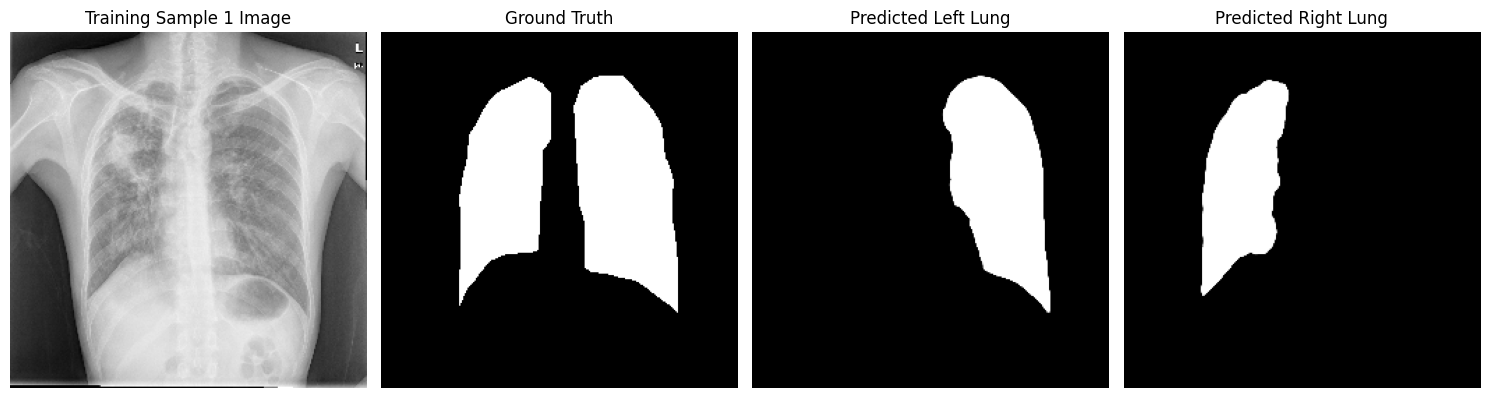

Training Sample 2 Dice Coefficient: 0.9754


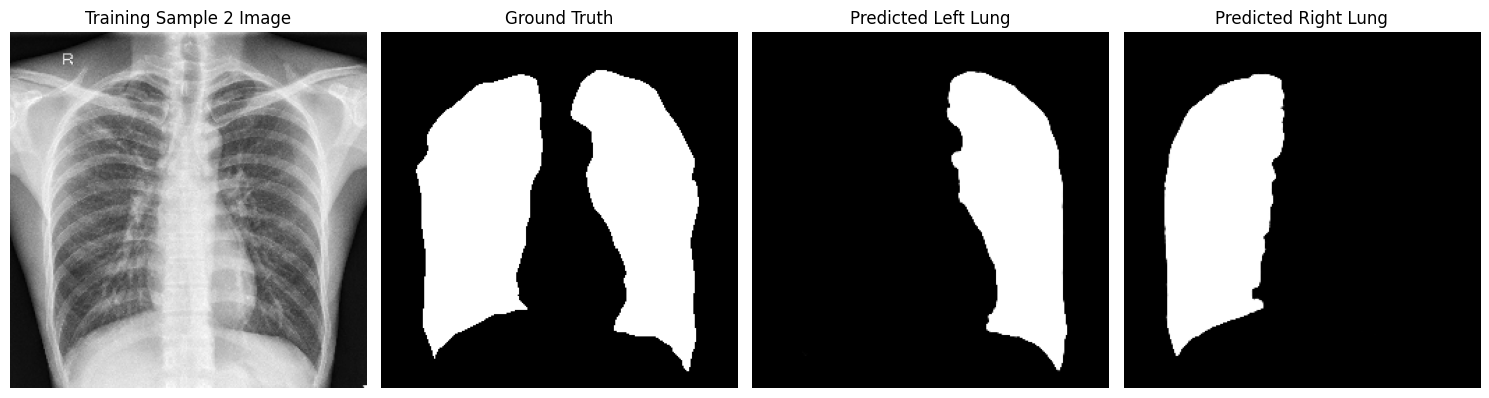

Training Sample 3 Dice Coefficient: 0.9733


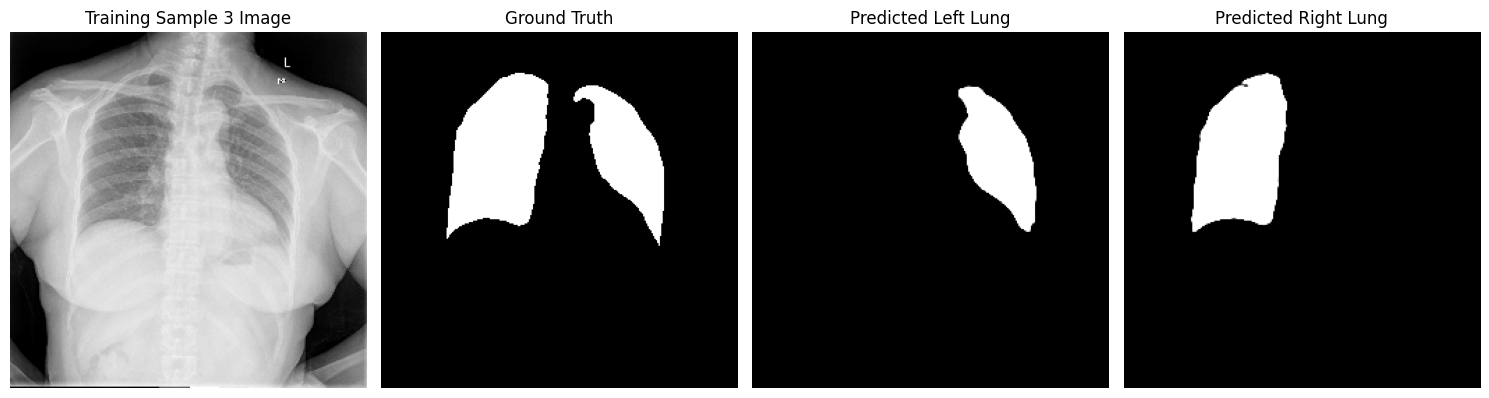


Validation Data Predictions:
Validation Sample 1 Dice Coefficient: 0.9804


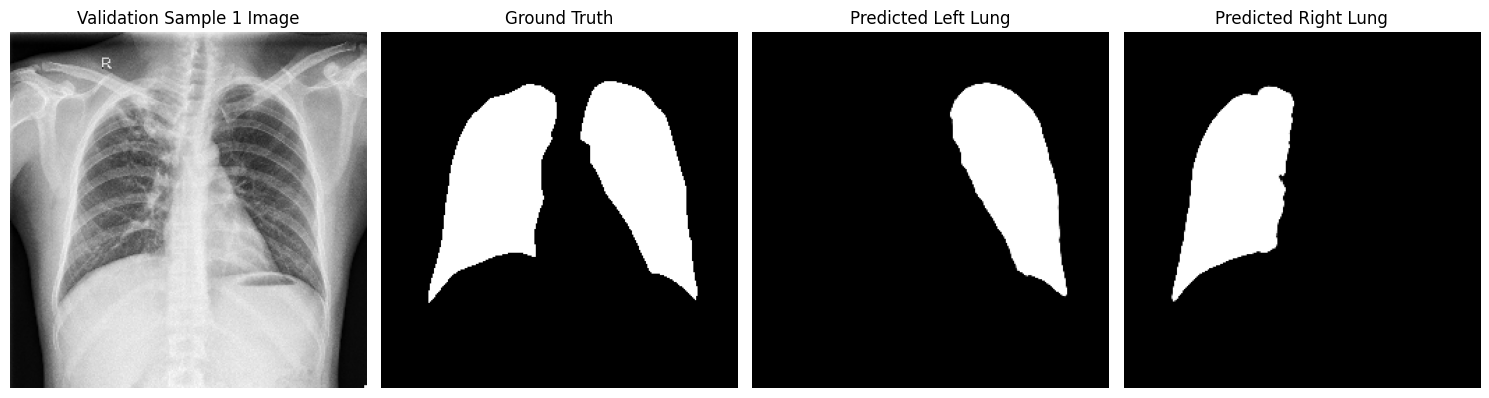

Validation Sample 2 Dice Coefficient: 0.9788


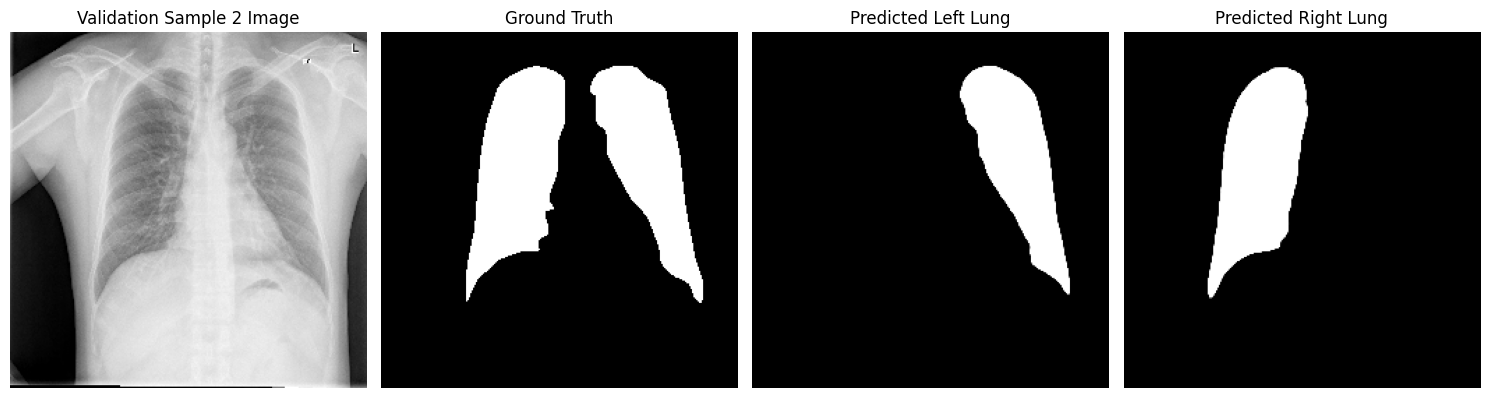

Validation Sample 3 Dice Coefficient: 0.9767


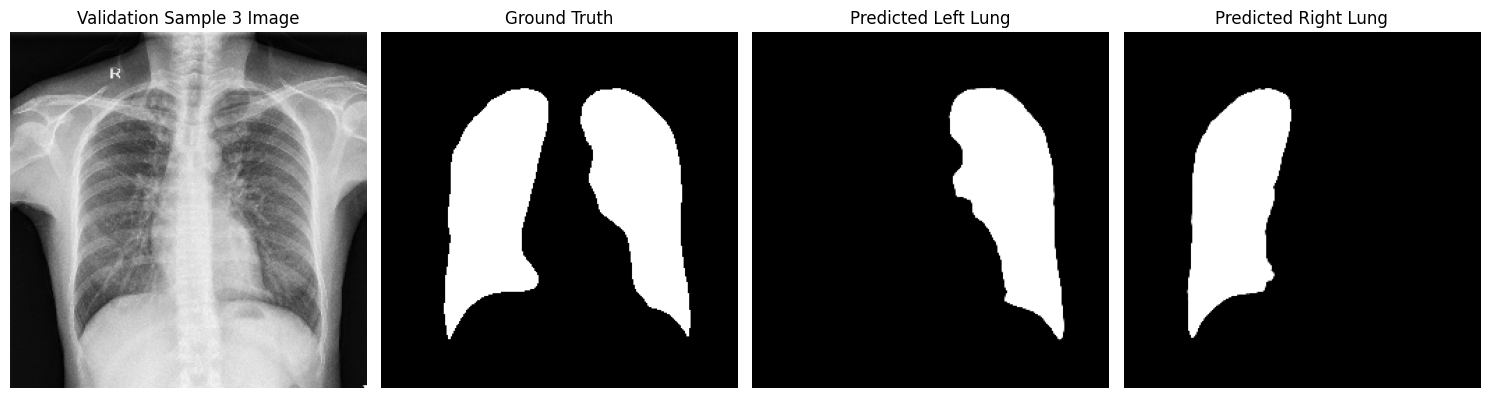


Test Data Predictions:
Test Sample 1 Dice Coefficient: 0.9803


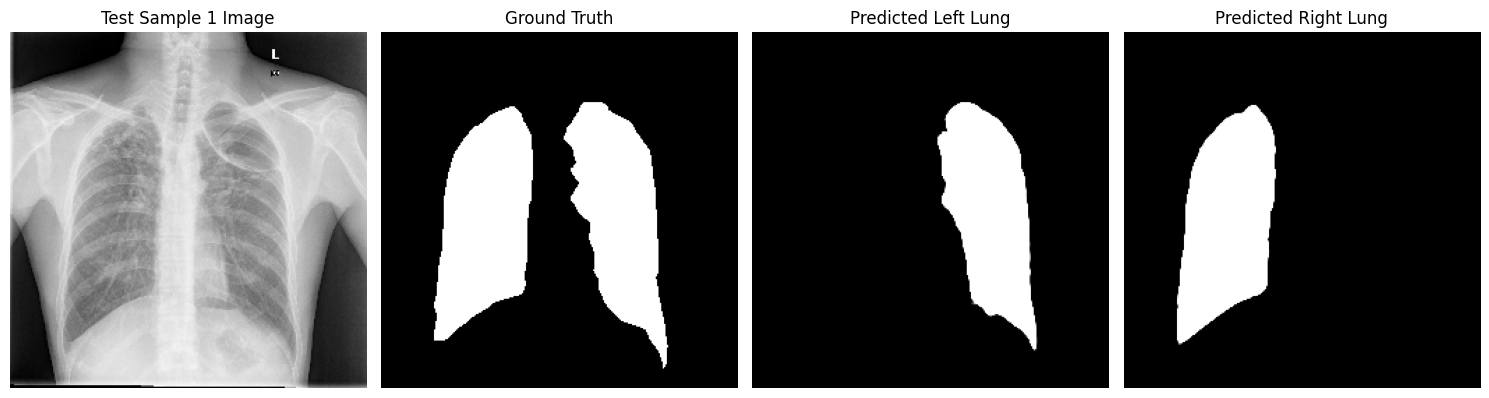

Test Sample 2 Dice Coefficient: 0.9796


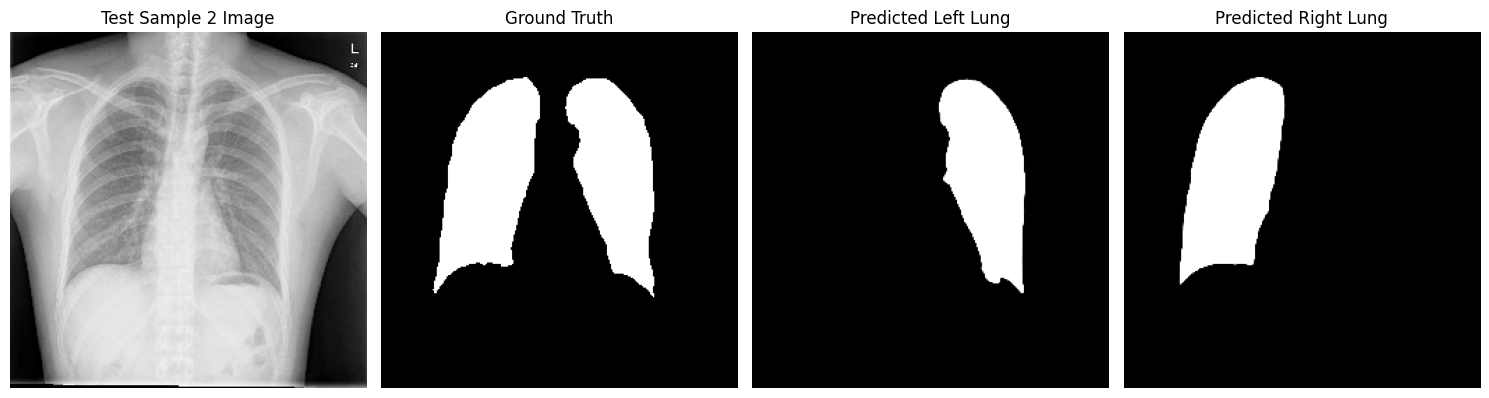

Test Sample 3 Dice Coefficient: 0.9813


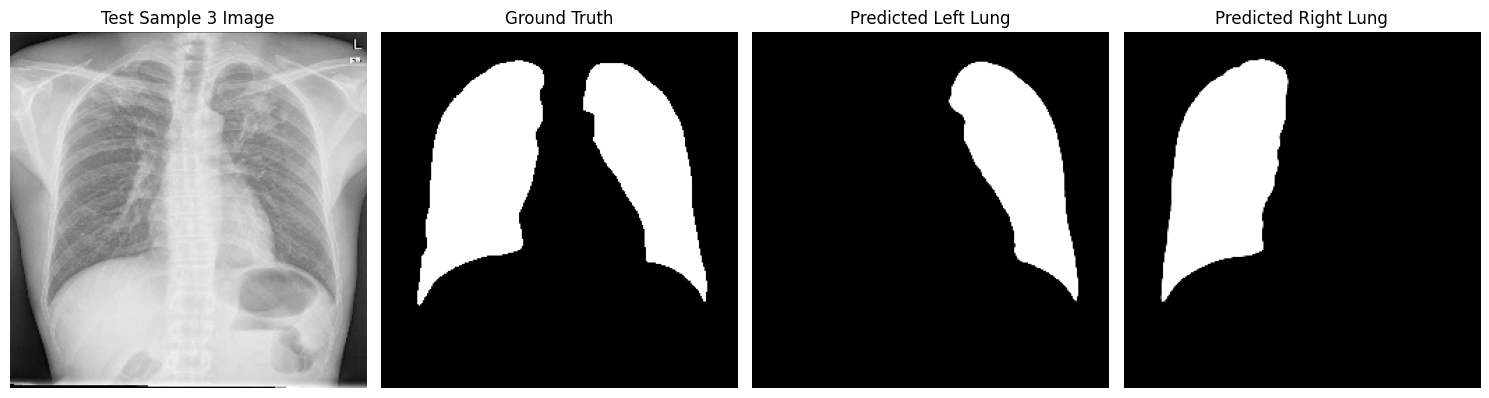

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, model):
    def plot_sample(X,y,pred,title_prefix):
        plt.figure(figsize=(15,5))

        #원본 이미지
        plt.subplot(1,4,1)
        plt.title(f"{title_prefix} Image")
        plt.imshow(X[0])
        plt.axis('off')

        #실제 마스크 (전체 폐)
        plt.subplot(1,4,2)
        plt.title("Ground Truth")

        #왼쪽 오른쪽 폐를 동시에 표시
        plt.imshow(y[0,:,:,1]+y[0,:,:,2], 'gray')
        plt.axis('off')

        #예측 마스크 (왼쪽 폐)
        plt.subplot(1,4,3)
        plt.title("Predicted Left Lung")
        plt.imshow(pred[0,:,:,1], 'gray')
        plt.axis('off')

        #예측 마스크 (오른쪽 폐)
        plt.subplot(1,4,4)
        plt.title("Predicted Right Lung")
        plt.imshow(pred[0,:,:,2],'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # 학습 데이터에서 3개 랜덤 샘플 예측
    print("Training Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_train_))
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Training Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_train, f"Training Sample {i+1}")

    # 검증 데이터에서 3개 랜덤 샘플 예측
    print("\nValidation Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_valid_))
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Validation Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_valid, f"Validation Sample {i+1}")

    # 테스트 데이터에서 3개 랜덤 샘플 예측
    print("\nTest Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_test_))
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Test Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_test, f"Test Sample {i+1}")

# 모델 예측 결과 시각화
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step
=== Worst 5 Cases ===


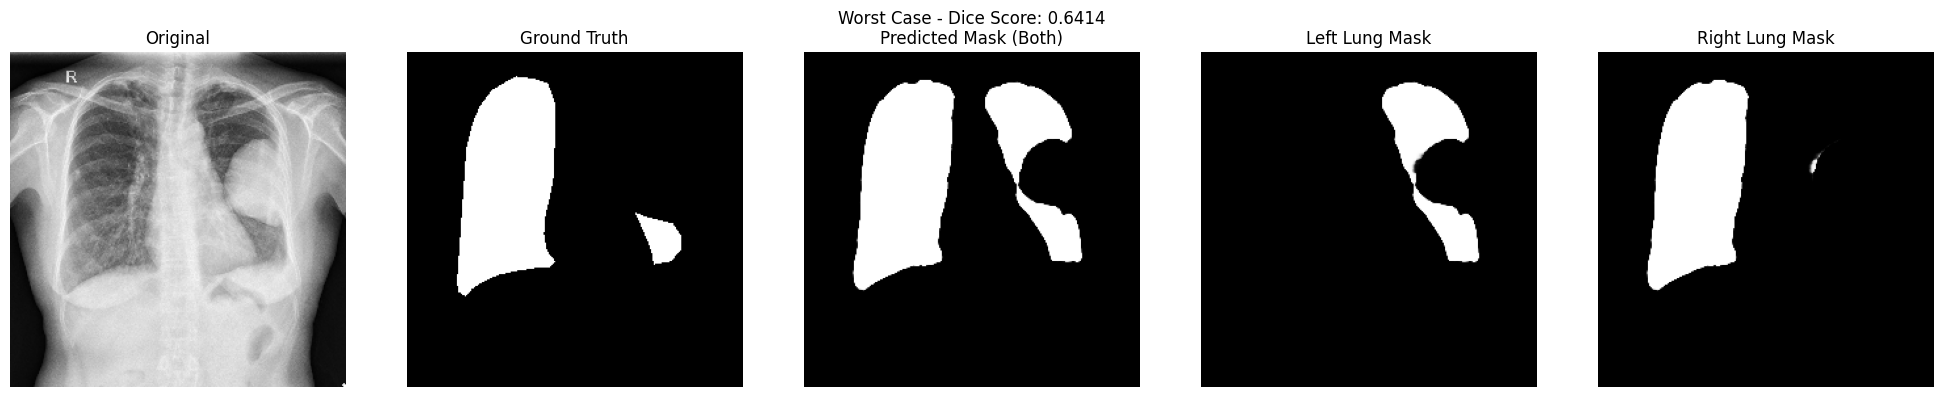

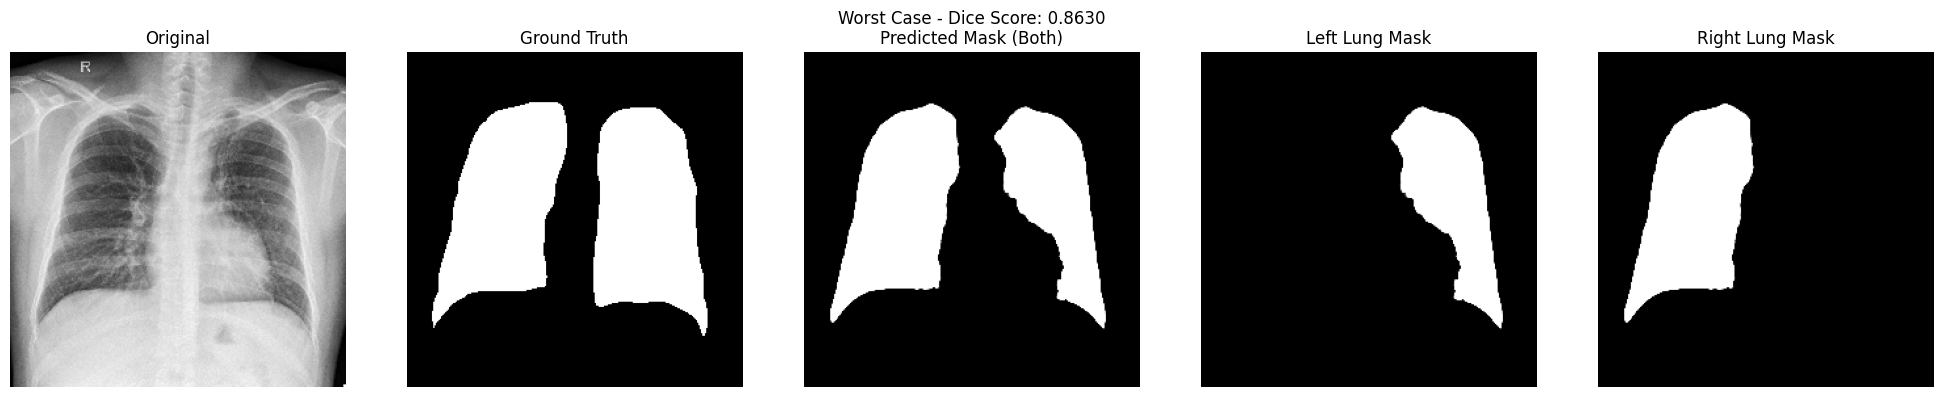

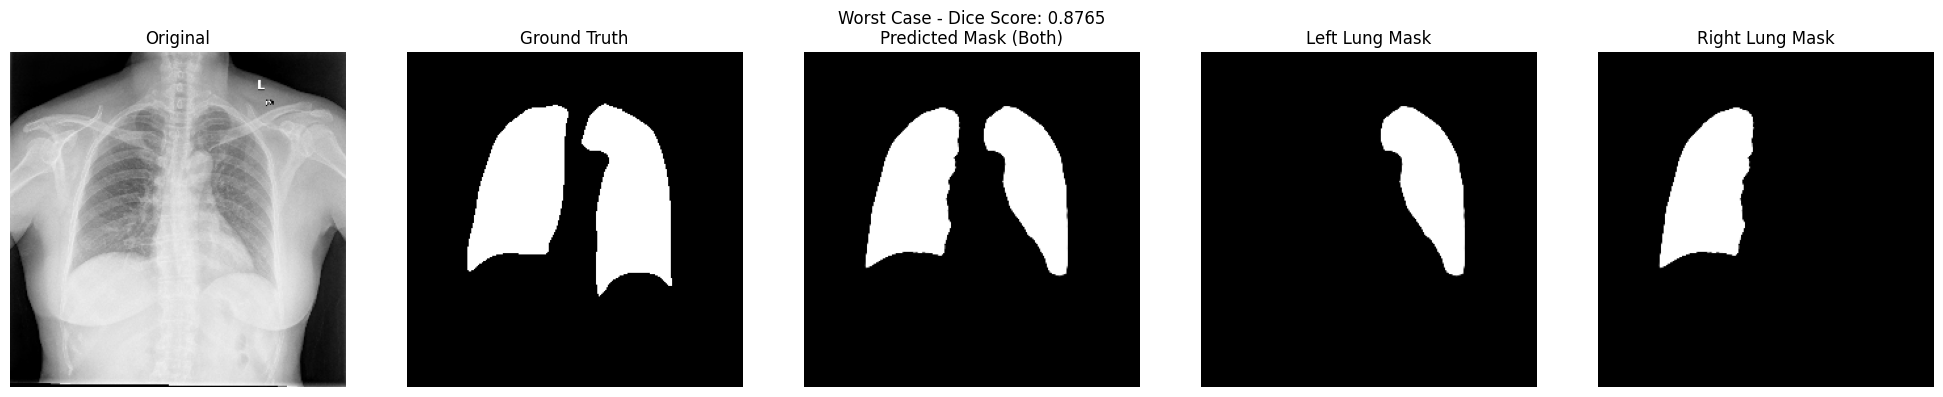

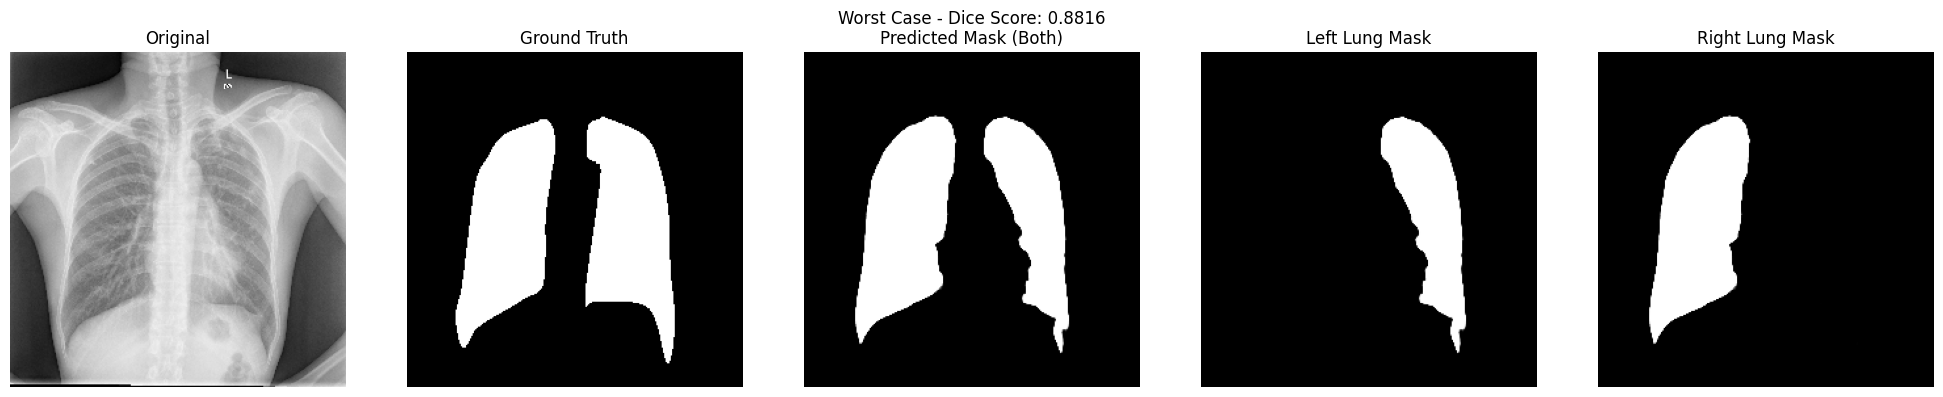

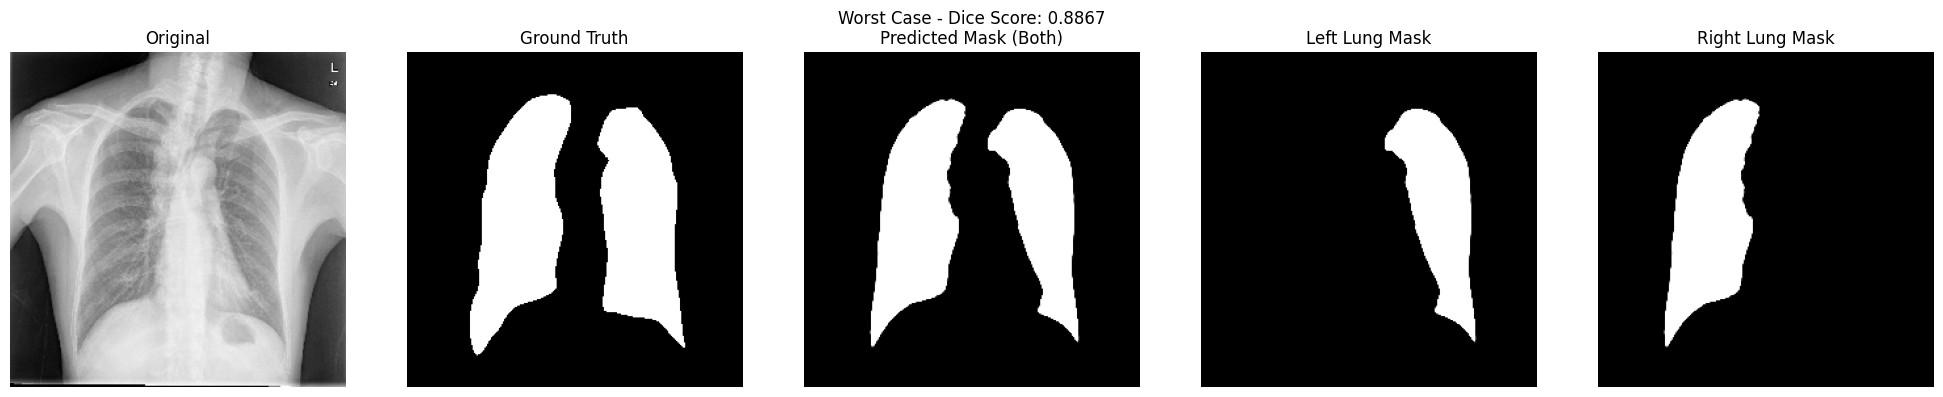


=== Best 5 Cases ===


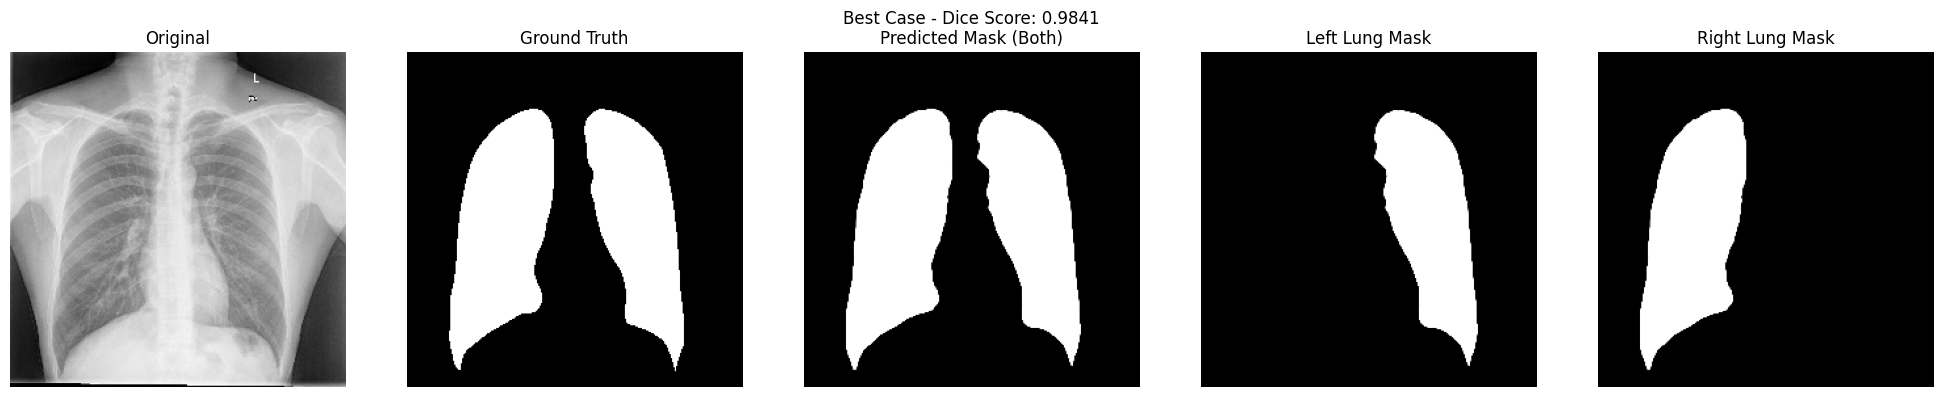

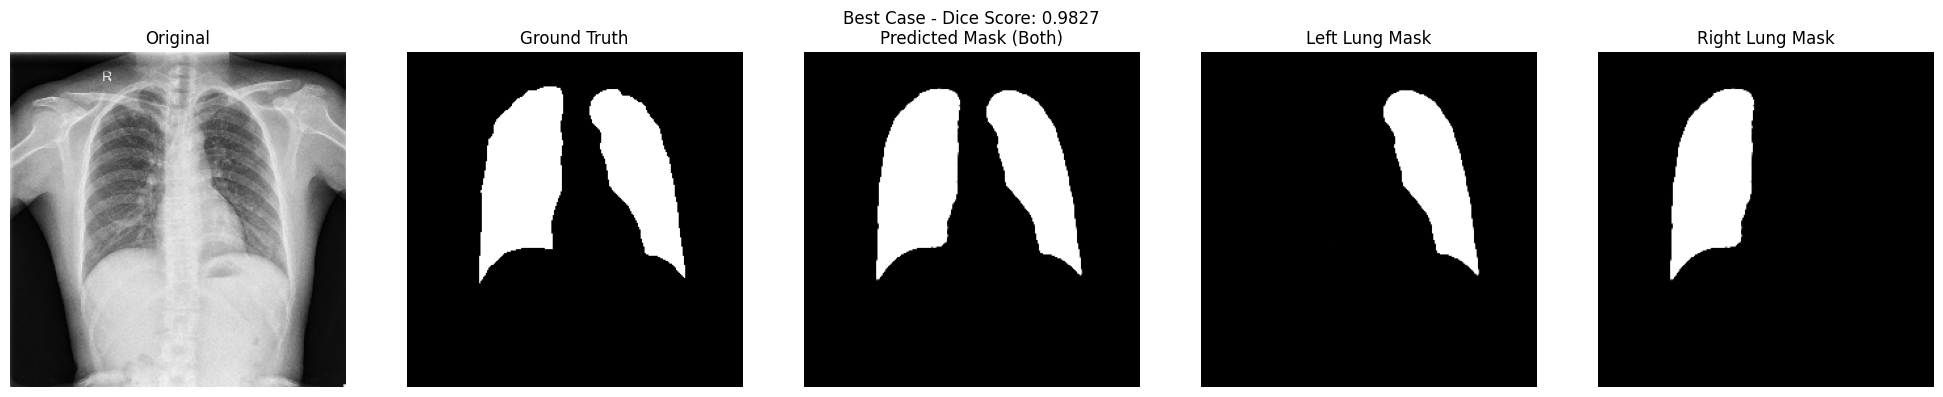

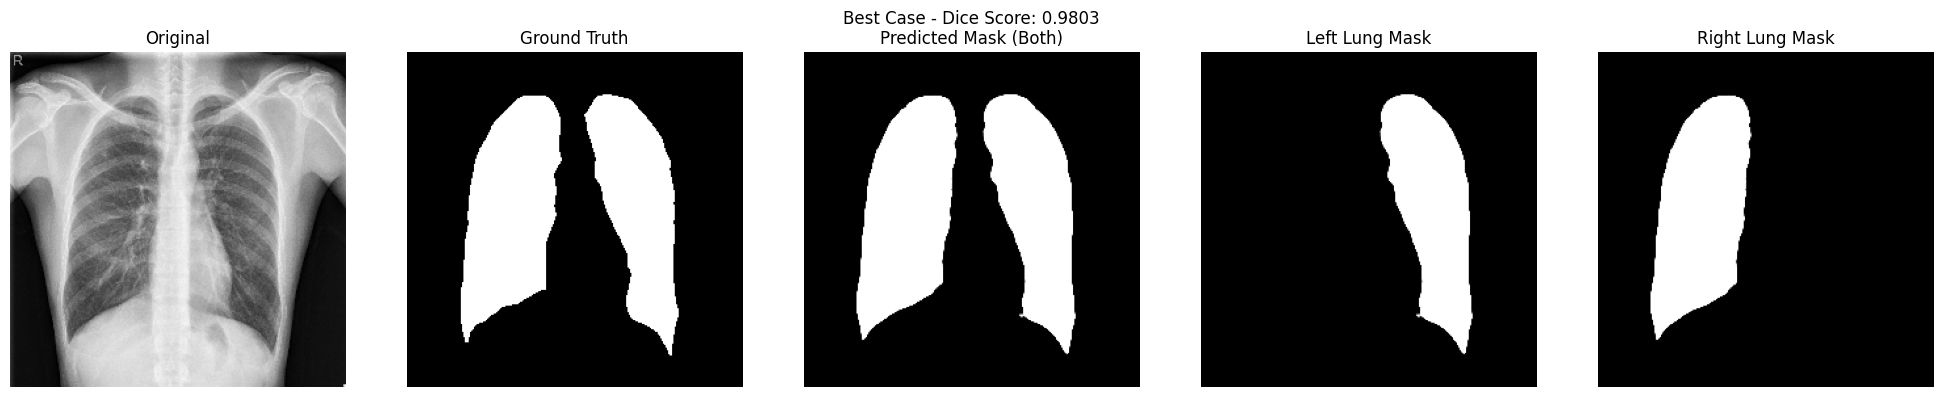

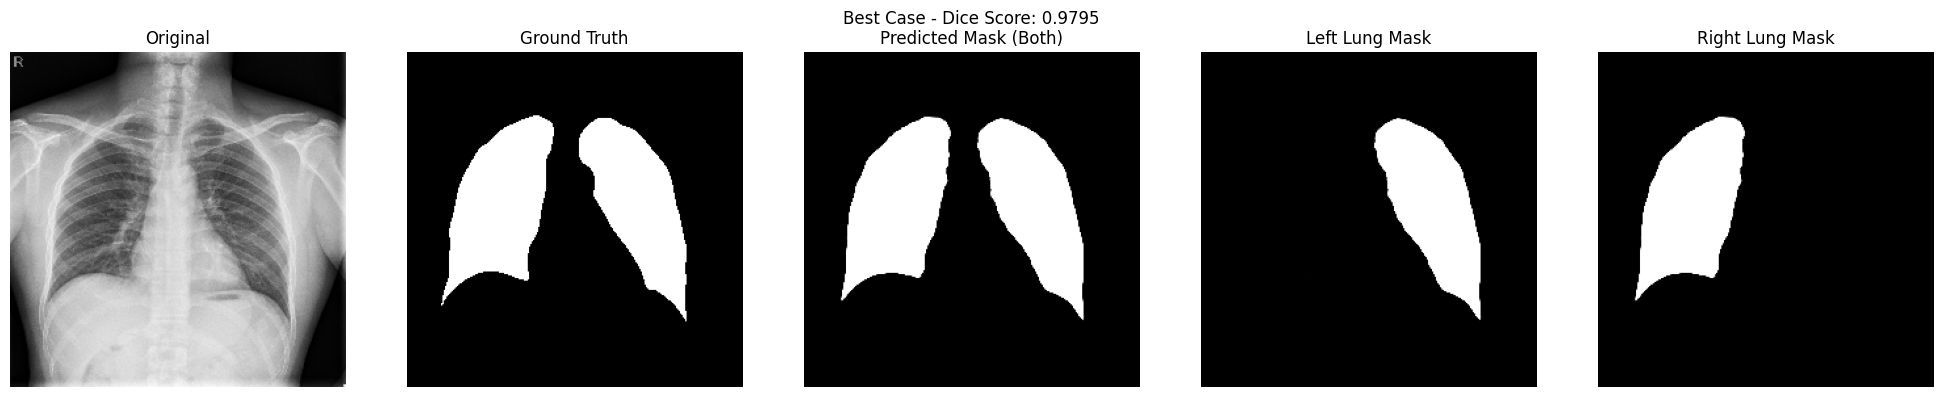

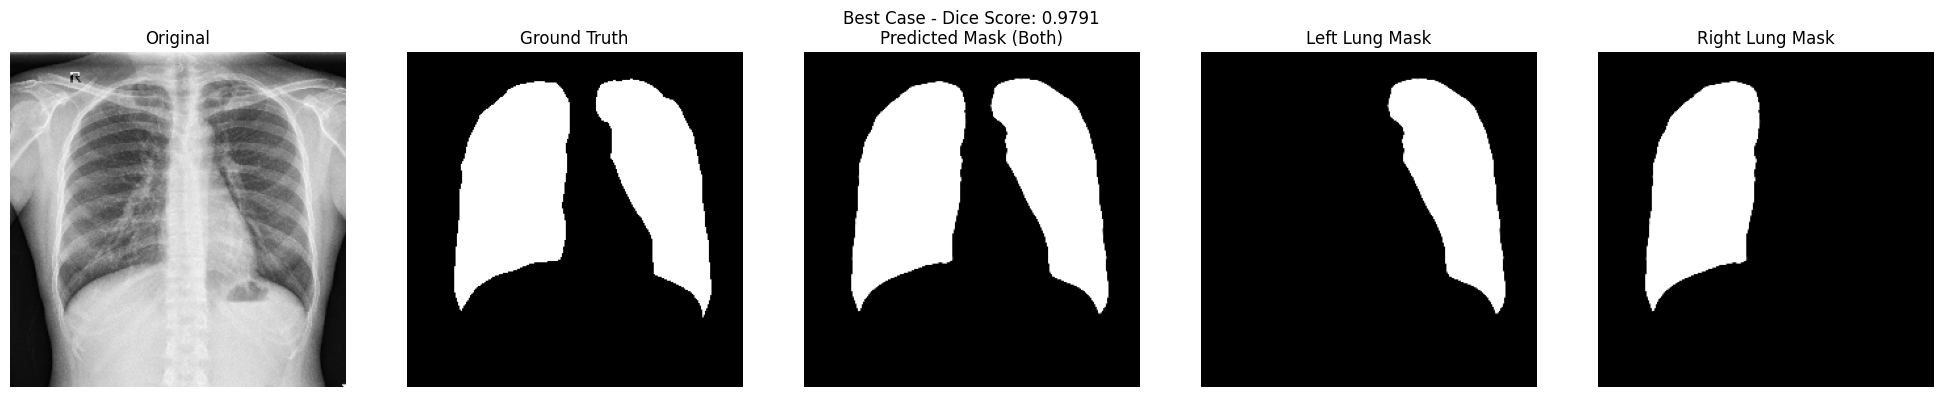

In [ ]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 각 이미지별 평균 Dice coefficient 계산
dice_scores = []
for i in range(len(X_test)):
    # 왼쪽과 오른쪽 폐에 대한 Dice 계산 (배경 제외)
    y_true_left = np.expand_dims(y_test[i,:,:,1], axis=0)
    y_true_right = np.expand_dims(y_test[i,:,:,2], axis=0)
    y_pred_left = np.expand_dims(y_pred[i,:,:,1], axis=0)
    y_pred_right = np.expand_dims(y_pred[i,:,:,2], axis=0)

    # Dice 계산
    left_dice = dice_coef(y_true_left, y_pred_left).numpy()
    right_dice = dice_coef(y_true_right, y_pred_right).numpy()
    avg_dice = (left_dice + right_dice) / 2
    dice_scores.append((i, avg_dice))

# Dice score 기준으로 정렬
sorted_dice = sorted(dice_scores, key=lambda x: x[1])
worst_5 = sorted_dice[:5]  # 하위 5개
best_5 = sorted_dice[-5:]  # 상위 5개

def visualize_results(indices, title):
    for idx, score in indices:
        plt.figure(figsize=(20,4))
        plt.suptitle(f"{title} - Dice Score: {score:.4f}")

        plt.subplot(1,5,1)
        plt.title("Original")
        plt.imshow(X_test[idx])
        plt.axis('off')

        plt.subplot(1,5,2)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx][:,:,1] + y_test[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.subplot(1,5,3)
        plt.title("Predicted Mask (Both)")
        plt.imshow(y_pred[idx][:,:,1] + y_pred[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.subplot(1,5,4)
        plt.title("Left Lung Mask")
        plt.imshow(y_pred[idx][:,:,1], 'gray')
        plt.axis('off')

        plt.subplot(1,5,5)
        plt.title("Right Lung Mask")
        plt.imshow(y_pred[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 시각화 실행
print("=== Worst 5 Cases ===")
visualize_results(worst_5, "Worst Case")

print("\n=== Best 5 Cases ===")
visualize_results(best_5[::-1], "Best Case")  # 역순으로 출력 (가장 좋은 것부터)